In [24]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares


matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [25]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IRdetection\Test_data\data_19_02_set1'

In [26]:
def reader(parent):

    data = {
        "res1" : [],
        "res2" : [],
        "res3" : [],
        "res4" : []
    }

    for folder in os.listdir(parent):
        if folder.startswith("T"):
            T = folder.replace('T_','')
            for file in os.listdir(parent + '/' + folder):
                dic = {
                    'F' : [],
                    'I' : [],
                    'Q' : [],
                    'S21' : []
                }
                with h5py.File(parent + '/' + folder + '/' + file, 'r') as f:
                    dic['F'] = np.array(f['raw_data']['f'][:])
                    dic['I'] = np.array(f['raw_data']['i'][:])
                    dic['Q'] = np.array(f['raw_data']['q'][:])
                    dic['S21'] = 20*np.log(np.sqrt(dic['I']**2 + dic['Q']**2))
                    dic['Phi'] = np.arctan(dic['I']/dic['Q'])
                    if '1' in file:
                        data['res1'].append([T, dic])
                    elif '2' in file:
                        data['res2'].append([T, dic])
                    elif '3' in file:
                        data['res3'].append([T, dic])
                    elif '4' in file:
                        data['res4'].append([T, dic])
    
    return data 

In [27]:
data = reader(parent)

In [28]:
F = np.array(data['res1'][0][1]['F'])
C = np.array(data['res1'][0][1]['Q'])+1j*np.array(data['res1'][0][1]['I'])
A = np.abs(C)
P = np.unwrap(np.angle(C))

In [29]:
A /= max(A)
F = (F - F[np.argmin(A)])/F[np.argmin(A)]

In [30]:
a = np.polyfit(F,P,1)
P = P - np.polyval(a,F)
print(a)

[2342.7781743     5.05764388]


In [31]:
A = A[np.argmin(A)-600:np.argmin(A)+600]
F = F[np.argmin(A)-600:np.argmin(A)+600]
P = P[np.argmin(A)-600:np.argmin(A)+600]

In [32]:
len_fit = int(np.floor(len(A)/10))
pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))        


len_fit = int(np.floor(len(P)/10))
pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

In [33]:
polyorder = 2

In [34]:
def resonance_model(x, pars):
    return 1-pars[1]*np.exp(1j*pars[2])/(1-1j*((2*x*pars[0])-pars[3]))

def fav(x, *pars):
    res = 1-pars[1]*np.exp(1j*pars[2])/(1-1j*((2*x*pars[0])-pars[3]))
    pol = np.polyval(pars[:polyorder+1], x)
    return pol+np.abs(res)

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.abs(res)+pol

def model2(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.unwrap(np.angle(res.real+pol+1j*res.imag))


In [35]:
p0 = [1e-6,1e-3,1,1e4, 0.5, 1, 0]
#p3 = [1,1,1,0.8,1,1]
#p0 = [4e3,5e3,-3]

In [36]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
##m.limits['x3'] = (0,1e4)
#m.limits['x4'] = (0,10)
m.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1221 (χ²/ndof = 1.0)       │              Nfcn = 998              │
│ EDM = 6.21e-06 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  -13.6e3  │   2.2e3   │            │            │         │         │       │
│ 1 │ x1   │   -38.1   │    2.8    │            │            │         │         │       │
│ 2 │ x2   │  -0.1092  │  0.0021   │            │            │         │         │       │
│ 3 │ x3   │  4.00e3   │  0.05e3   │            │            │         │         │       │
│ 4 │ x4   │   0.801   │   0.007   │            │            │         │         │       │
│ 5 │ x5   │   0.077   │   0.008   │            │            │         │         │       │
│ 6 │ x6   │   -4.01   │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────────────────────────────────────┐
│    │         x0         x1         x2         x3         x4         x5         x6 │
├────┼──────────────────────────────────────────────────────────────────────────────┤
│ x0 │   4.87e+06    4.996e3  -3.419543     72.8e3   -2.47683    1.37877   -72.0045 │
│ x1 │    4.996e3       7.61  -2.218e-3         76   -2.88e-3   -7.22e-3    -0.0857 │
│ x2 │  -3.419543  -2.218e-3   4.54e-06 -78.977e-3       2e-6      -6e-6      73e-6 │
│ x3 │     72.8e3         76 -78.977e-3   2.98e+03   95.64e-3   25.98e-3    -2.9692 │
│ x4 │   -2.47683   -2.88e-3       2e-6   95.64e-3   5.62e-05         -0   -0.10e-3 │
│ x5 │    1.37877   -7.22e-3      -6e-6   25.98e-3         -0   6.95e-05    0.06e-3 │
│ x6 │   -72.0045    -0.0857      73e-6    -2.9692   -0.10e-3    0.06e-3    0.00308 │
└────┴──────────────────────────────────────────────────────────────────────────────┘

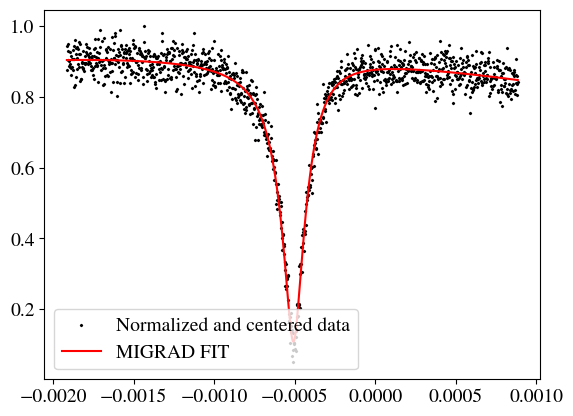

In [37]:
#plt.errorbar(F,A,np.ones_like(A)*A_rms,linestyle='')
plt.scatter(F,A,s=2,marker='x',color='black',label='Normalized and centered data')
plt.plot(F,model(F,*m.values),color='red',label='MIGRAD FIT')
plt.legend()

In [38]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,-13.6e3,2.2e3,,,,,
1,x1,-38.1,2.8,,,,,
2,x2,-0.1092,0.0021,,,,,
3,x3,4.00e3,0.05e3,,,,,
4,x4,0.801,0.007,,,,,
5,x5,0.077,0.008,,,,,
6,x6,-4.01,0.06,,,,,


In [39]:
Q = m.values[polyorder+1]
R = m.values[polyorder+2]
phi = m.values[polyorder+3]
Qi = Q/(1-R*(np.cos(phi)))
Qc = Q/(R*(np.cos(phi)))

print('Q_t = ', Q)
print('Q_c = ', Qc)
print('Q_i = ', Qi)

Q_t =  4001.695775331025
Q_c =  5012.509425306134
Q_i =  19843.952237436082


In [40]:
lsq = LeastSquares(F,P,P_rms*np.ones(len(P)),model2)
m= minuit.Minuit(lsq, *p0)
m.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8013 (χ²/ndof = 6.7)       │              Nfcn = 567              │
│ EDM = 3.6e-05 (Goal: 0.0002)     │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.18e6   │  0.14e6   │            │            │         │         │       │
│ 1 │ x1   │    109    │    22     │            │            │         │         │       │
│ 2 │ x2   │   -0.47   │   0.06    │            │            │         │         │       │
│ 3 │ x3   │  3.371e3  │  0.028e3  │            │            │         │         │       │
│ 4 │ x4   │   0.49    │   0.05    │            │            │         │         │       │
│ 5 │ x5   │   0.080   │   0.008   │            │            │         │         │       │
│ 6 │ x6   │   0.112   │   0.008   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────┐
│    │          x0          x1          x2          x3          x4          x5          x6 │
├────┼─────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │    1.81e+10    1.8445e6 7.5000515e3    -705.8e3 6.9621992e3   135.69912   131.48021 │
│ x1 │    1.8445e6         476      0.7645          -0      0.7151   131.23e-3   134.39e-3 │
│ x2 │ 7.5000515e3      0.7645     0.00337      0.0289      0.0031     0.04e-3     0.04e-3 │
│ x3 │    -705.8e3          -0      0.0289         764      0.0265    -2.12e-3     6.02e-3 │
│ x4 │ 6.9621992e3      0.7151      0.0031      0.0265      0.0029     0.04e-3     0.04e-3 │
│ x5 │   135.69912   131.23e-3     0.04e-3    -2.12e-3     0.04e-3    6.41e-05     0.07e-3 │
│ x6 │   131.48021   134.39e-3     0.04e-3     6.02e-3     0.04e-3     0.07e-3    6.78e-05 │
└────┴─────────────────────────────────────────────────────────────────────────────────────┘

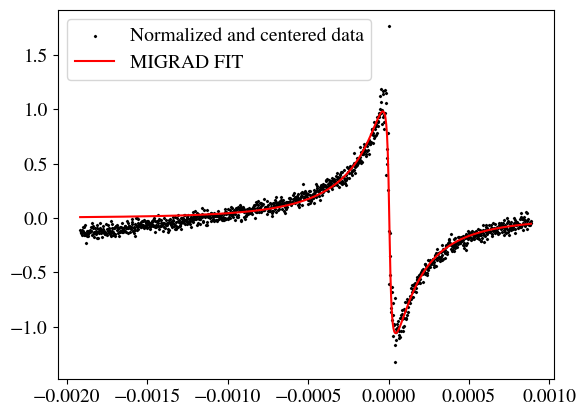

In [41]:
#plt.errorbar(F,A,np.ones_like(A)*A_rms,linestyle='')
plt.scatter(F,P,s=2,marker='x',color='black',label='Normalized and centered data')
plt.plot(F,model2(F,*m.values),color='red',label='MIGRAD FIT')
plt.legend()

In [42]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,1.18e6,0.14e6,,,,,
1,x1,109,22,,,,,
2,x2,-0.47,0.06,,,,,
3,x3,3.371e3,0.028e3,,,,,
4,x4,0.49,0.05,,,,,
5,x5,0.080,0.008,,,,,
6,x6,0.112,0.008,,,,,


In [43]:
Q = m.values[polyorder+1]
R = m.values[polyorder+2]
phi = m.values[polyorder+3]
Qi = Q/(1-R*(np.cos(phi)))
Qc = Q/(R*(np.cos(phi)))

print('Q_t = ', Q)
print('Q_c = ', Qc)
print('Q_i = ', Qi)

Q_t =  3370.918084359722
Q_c =  6878.795410667434
Q_i =  6610.224272818674
